This project is aim for the segmentation of hard exudate using advancd image analysis (Grey scale morphology, and thresholding) and Machine Learning 

Group members are:
1. Taofik Ahmed Suleiman
2. Daniel Tweneboah Anyimadu
3. Hadeel Awwad
4. Hsham Abdalgny Abdalwhab Ngim
5. Melika Pooyan

### PREPROCESSING, SEGMENTATION AND FEATURE EXTRACTION

#### Import all the needed libraries

In [1]:
import numpy as np
import scipy as sp 
import scipy.ndimage as ndimage
import math
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import warnings

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.metrics import roc_curve, auc


from sklearn.utils import shuffle

#### Defining the functions for opical disc segmentation

1. Gamma correction
2. Linear stretching

In [2]:
def gammaCorrection(image,gamma):
    c = 255**(1-gamma)
    return (c *(image**gamma)).astype("uint8")

def linearStretching(img):
    hf_counts, hf_bins = np.histogram(img.flatten(), bins=256, range=(0,255))
    s1, s2 =  int(np.argwhere(hf_counts>0)[0]), int(np.argwhere(hf_counts>0)[-1])
    t1, t2 = 0, 255
    return ((img-s1)*((t2-t1)/(s2-s1)+t1)).astype("uint8")


#### Defining the functions for the preprocessing and segmentation

For the preprocessing:
1. Median blurring
2. CLAHE

For the segmentation
1. Blackhat
2. Tophat
3. LAB color space transformation

In [3]:
# Defining functions for the preproceesing
def preprocess_image(img):
    img_med = cv2.medianBlur(img, 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
    img_enhanced = clahe.apply(img_med)
    return img_enhanced

# Defining functions for the segmentation
def apply_blackhat(img, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    img_bh = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    return img_bh

def apply_tophat(img, kernel_size):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    img_th = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return img_th

def lab_color_space_transform(img, kernel_size):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(img_lab)
    ret, img_labt = cv2.threshold(L, 4, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    img_erode = cv2.erode(img_labt, kernel, iterations=2)
    img_erode = ndimage.binary_fill_holes(img_erode)
    img_erode = np.array(img_erode, np.uint8)
    return img_erode

#### Defining the functions for the performance evaluation of the segmentation

The evaluation metrics used is the intersection over union (IoU)

In [4]:
def evaluation(region_img, region_mask):
    intersection = np.sum(np.logical_and(region_img != 0, region_mask != 0))
    union = np.sum(np.logical_or(region_img != 0, region_mask != 0))

    if union != 0:
        iou = intersection / union
    else:
        iou = 0

    return iou

#### Defining the functions for the feature extraction

We have extracted the following features
1. Intensity-based features
2. Gray-Level Co-occurrence Matrix (GLCM) features
3. Gabor filters 
4. Shape descriptors (Hu moments, area, perimeter, and eccentricity)

We also created a function to detect all the contours in our segmented images and identify the locations to our original image for feature extraction and also to the ground truth for IoU evaluation. Also, a function  to save the extracted files to csv for further analysis

In [5]:
# Function to extract intensity-based features
def extract_intensity_features (original_roi):
    mean_intensity = np.mean(original_roi)
    std_intensity = np.std(original_roi)
    max_intensity = np.max(original_roi)
    min_intensity = np.min(original_roi)
    intensity_features = {
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'max_intensity': max_intensity,
        'min_intensity': min_intensity
    }
    return intensity_features


# Function to extract Gray-Level Co-occurrence Matrix (GLCM) features
def extract_glcm_features(original_roi):
    glcm_features = pd.DataFrame()
    params = [(1, 0), (2, 0), (5, 0),
              (1, np.pi/4), (2, np.pi/4), (5, np.pi/4),
              (1, np.pi/2), (2, np.pi/2), (5, np.pi/2)]
    for i, (d, a) in enumerate(params):
        GLCM = graycomatrix(original_roi, [d], [a])
        GLCM_Energy = graycoprops(GLCM, 'energy')[0]
        glcm_features['Energy'+str(i+1)] = GLCM_Energy
        GLCM_corr = graycoprops(GLCM, 'correlation')[0]
        glcm_features['Correlation'+str(i+1)] = GLCM_corr
        GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
        glcm_features['Dissimilarity'+str(i+1)] = GLCM_diss
        GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
        glcm_features['Homogeneity'+str(i+1)] = GLCM_hom
        GLCM_contr = graycoprops(GLCM, 'contrast')[0]
        glcm_features['Contrast'+str(i+1)] = GLCM_contr
    return glcm_features


# Function to extract Gabor filter features
def extract_gabor_feature(original_roi):
   # img_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    gabor_features1 = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(original_roi, kernel, mode='wrap')
        gabor_features1[k, 0] = filtered.mean()
        gabor_features1[k, 1] = filtered.var()
    gabor_features1 = gabor_features1.flatten()
    gabor_features = {f'Gabor{i}': gabor_features1[i] for i in range(len(gabor_features1))}
    return gabor_features


# Function to extract the Hu Moments
def extract_hu_moments(roi_proc):
    moments = cv2.moments(roi_proc)
    hu_moments = cv2.HuMoments(moments)
    hu_moments = np.array(hu_moments).reshape(1, -1)
    hu_features = pd.DataFrame(hu_moments, columns=['Hu_moment'+str(i) for i in range(hu_moments.shape[1])])
    return hu_features

# Function to extract geometric shape descriptors
def extract_shape_feature(region, w, h):
    shape_features = pd.DataFrame()
    area = cv2.contourArea(region)
    perimeter = cv2.arcLength(region, True)
    eccentricity = w/h
    shape_features['Area'] = [area]
    shape_features['Perimeter'] = [perimeter]
    shape_features['Eccentricity'] = [eccentricity]
    return shape_features

# Overall function to combine all the extracted features and build the labels from the IoU
def all_candidates_region_selection(original_img, processed_img, groundtruth):
    contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx = 0
    intensity_features = pd.DataFrame()
    glcm_features = pd.DataFrame()
    gabor_features = pd.DataFrame()
    hu_features = pd.DataFrame()
    shape_features = pd.DataFrame()
    iou_list = []
    label_list = []
    image_features = pd.DataFrame()
    region_number = 1

    for cnt in contours:
        idx += 1
        x, y, w, h = cv2.boundingRect(cnt)
        roi_proc_img = processed_img[y:y+h, x:x+w]
        roi_mask = groundtruth[y:y+h, x:x+w]
        iou = evaluation(roi_proc_img, roi_mask)
        b, g, r = cv2.split(original_img)

        warnings.filterwarnings("ignore", category=FutureWarning)
        
        # Call the functions to extract the images
        intensity_features = intensity_features.append(extract_intensity_features(g[y:y+h, x:x+w]), ignore_index=True)
        glcm_features = glcm_features.append(extract_glcm_features(g[y:y+h, x:x+w]), ignore_index=True)
        gabor_features = gabor_features.append(extract_gabor_feature(g[y:y+h, x:x+w]), ignore_index=True)
        hu_features = hu_features.append(extract_hu_moments(roi_proc_img), ignore_index=True)
        shape_features = shape_features.append(extract_shape_feature(cnt, w, h), ignore_index=True)
        
        # Combine all the features into one data frame
        image_features = pd.concat([intensity_features, glcm_features, gabor_features, hu_features, shape_features], axis=1)
        
        # Create IoU list and assign label 1 for IOU >= 0.5, otherwise 0
        iou_list.append(iou)
        label = 1 if iou >= 0.5 else 0 
        label_list.append(label)
        region_number += 1

    # Add Image number and Region number columns
    image_features.insert(0, 'Image number', image_number)
    image_features.insert(1, 'Region', range(1, region_number))

    return image_features, label_list


# Save the data to CSV file
def save_features_to_csv(dataframe, file_name, header=True):
    if os.path.isfile(file_name):
        # If the file already exists, append the data to it
        dataframe.to_csv(file_name, mode='a', header=False, index=False)
    else:
        # If the file does not exist, create it and write the data to it
        dataframe.to_csv(file_name, mode='w', header=True, index=False)

#### Defining the function to count the true exudates in the groundtruth

This is needed during the final performance evaluation after machine learning

In [6]:
def countGroundtruth(groundtruth):
    contours1, hierarchy1 = cv2.findContours(groundtruth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    exudate_count = len(contours1)
  
    return exudate_count

total_exudate_count = 0

#### Codes to perform all the task to which all the functions was created.

1. Load the datasets and their corresponding ground truth
2. Code for the optical disc segmentation and removal
3. Preprocessing and segmentation of candidate region (hard exudate)

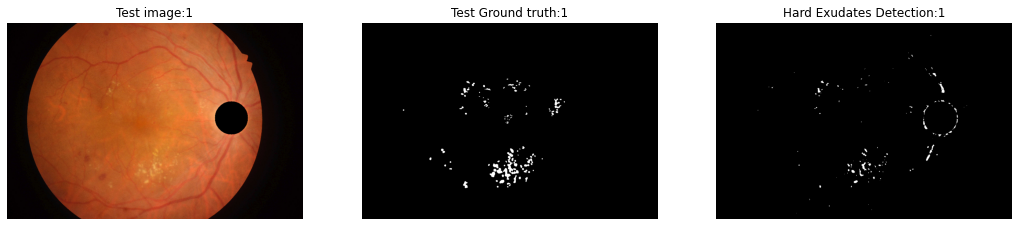

Shape of Features: (146, 94)


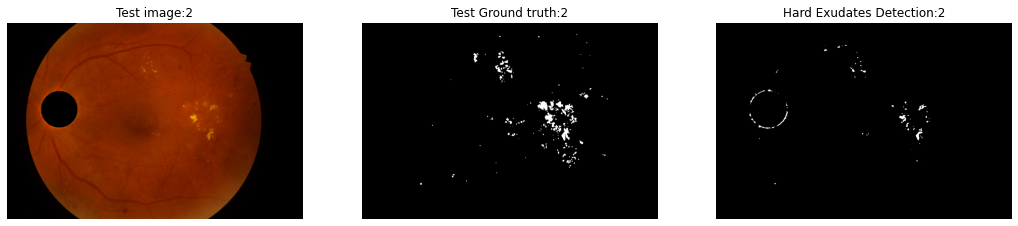

Shape of Features: (84, 94)


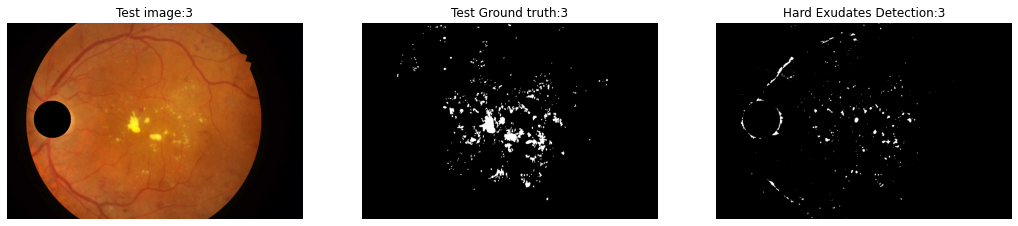

Shape of Features: (346, 94)


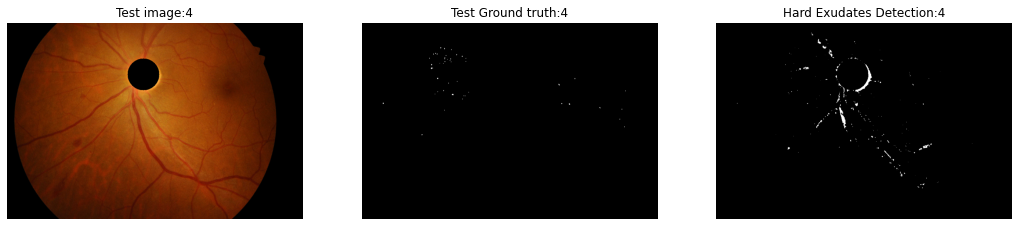

Shape of Features: (204, 94)


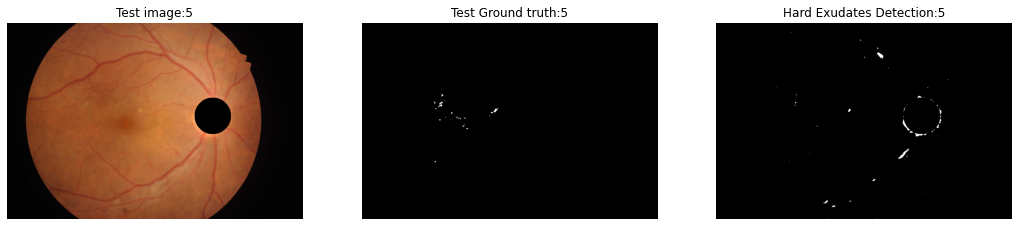

Shape of Features: (84, 94)


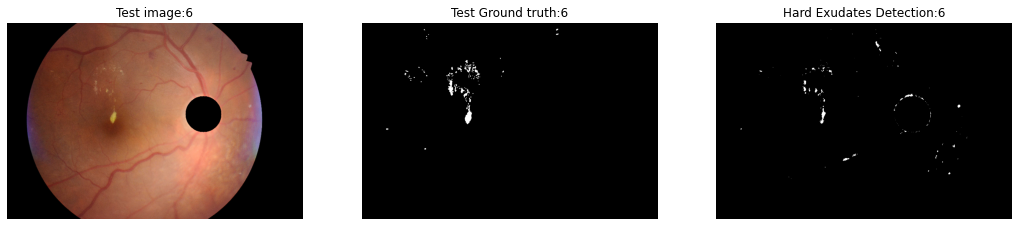

Shape of Features: (147, 94)


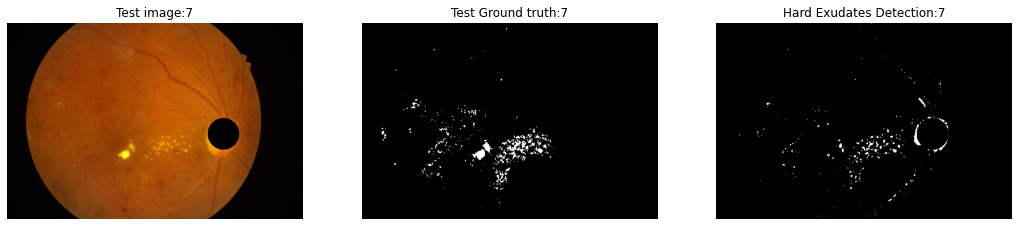

Shape of Features: (343, 94)


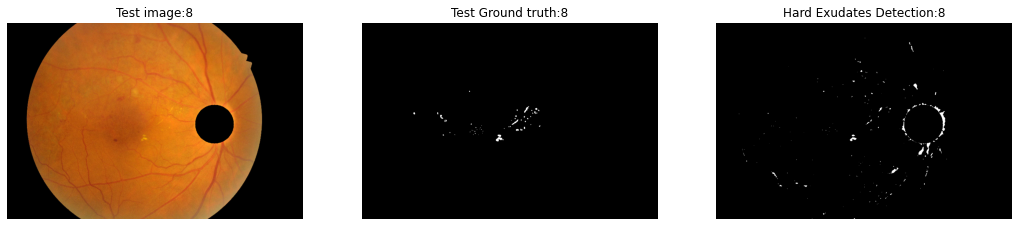

Shape of Features: (225, 94)


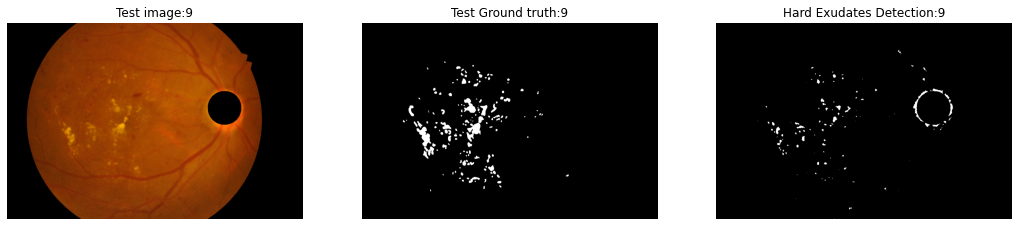

Shape of Features: (135, 94)


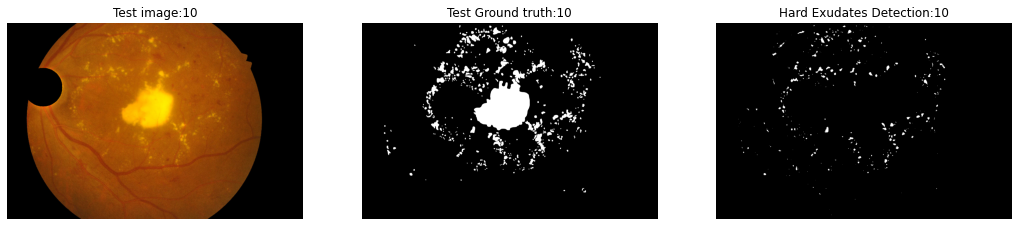

Shape of Features: (374, 94)


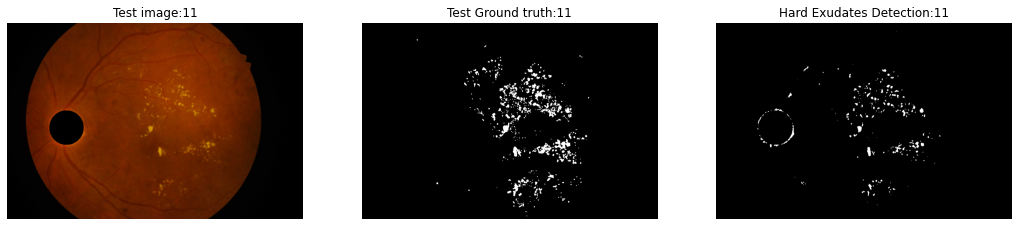

Shape of Features: (232, 94)


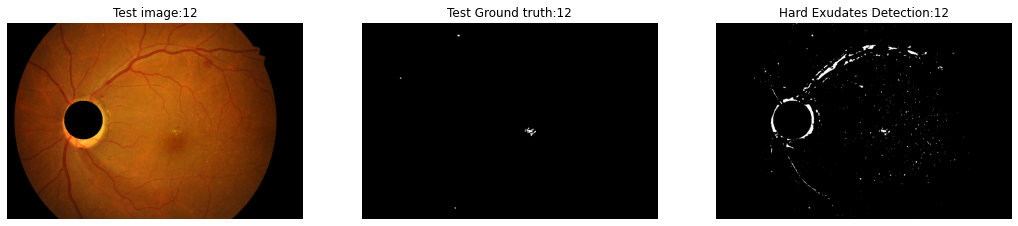

Shape of Features: (578, 94)


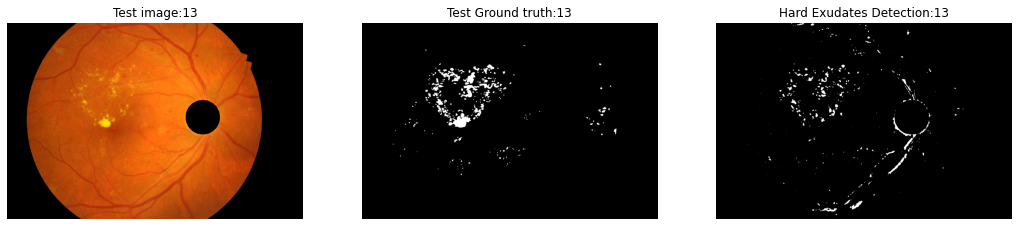

Shape of Features: (392, 94)


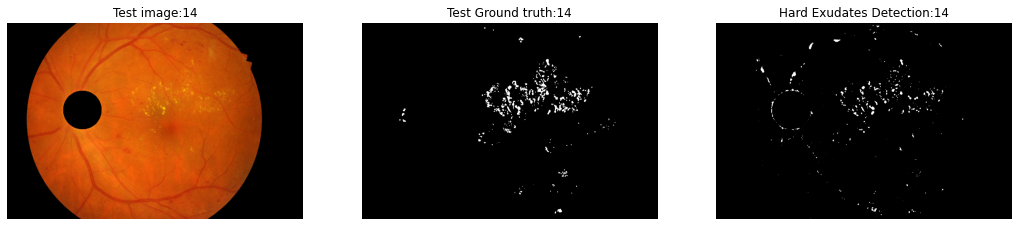

Shape of Features: (353, 94)


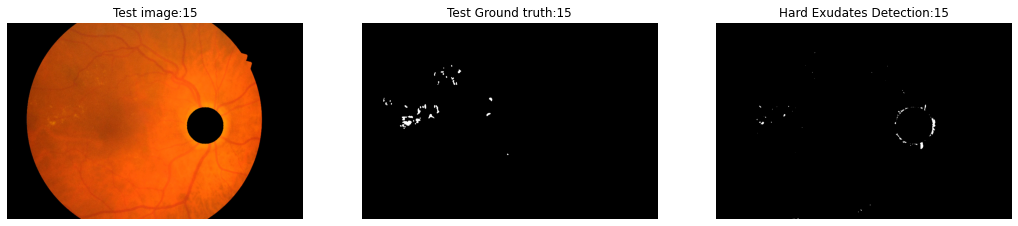

Shape of Features: (67, 94)


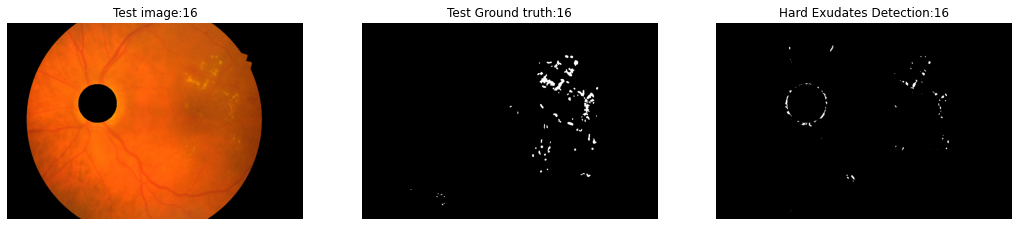

Shape of Features: (85, 94)


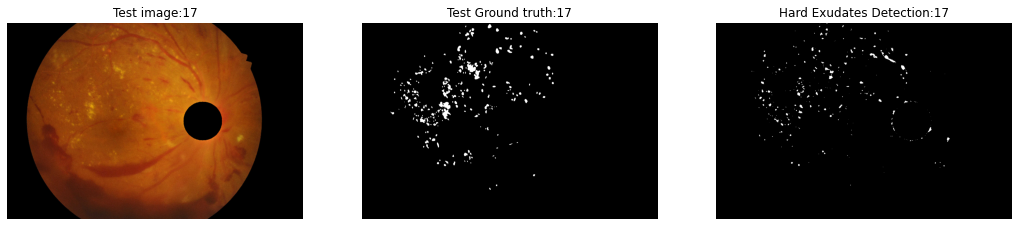

Shape of Features: (293, 94)


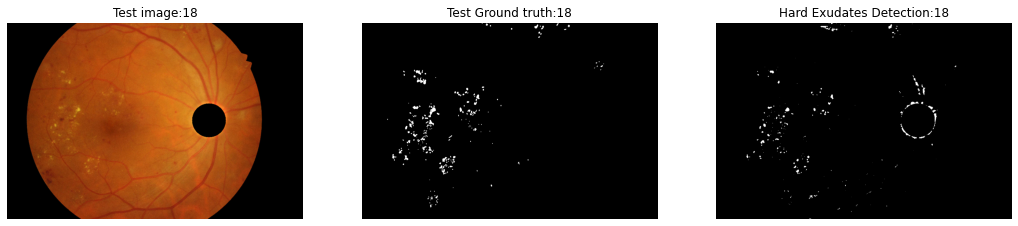

Shape of Features: (253, 94)


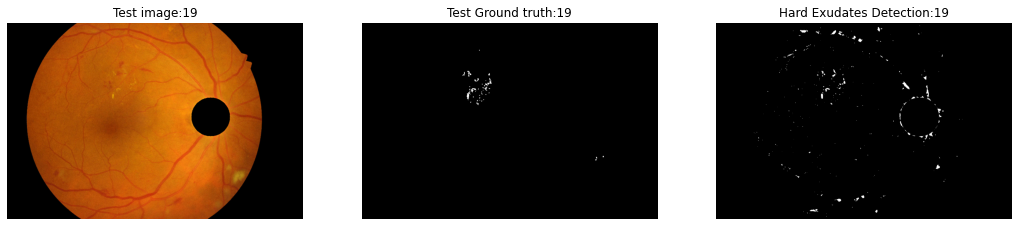

Shape of Features: (328, 94)


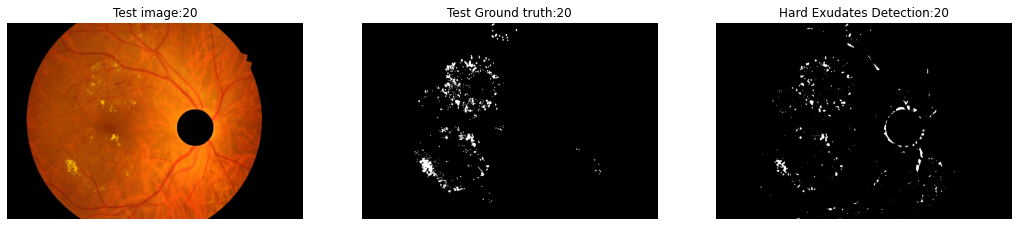

Shape of Features: (396, 94)


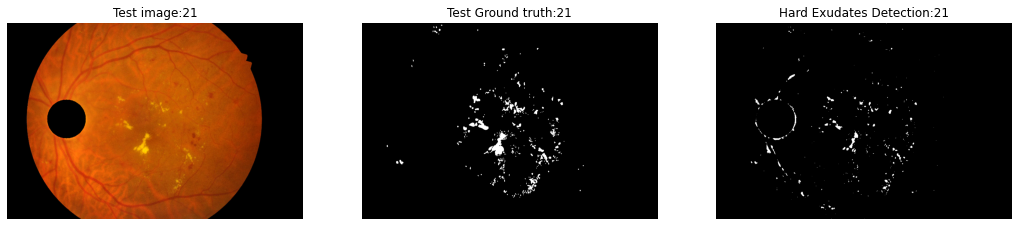

Shape of Features: (329, 94)


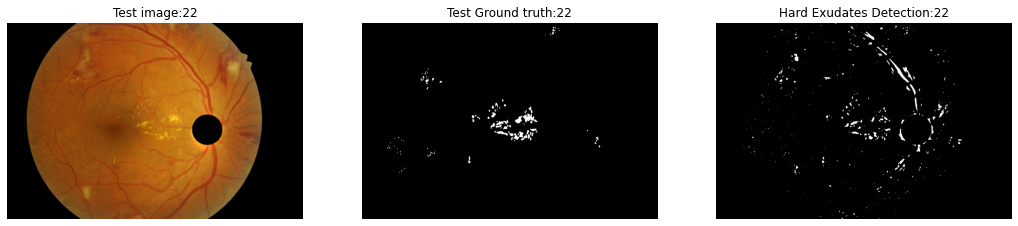

Shape of Features: (588, 94)


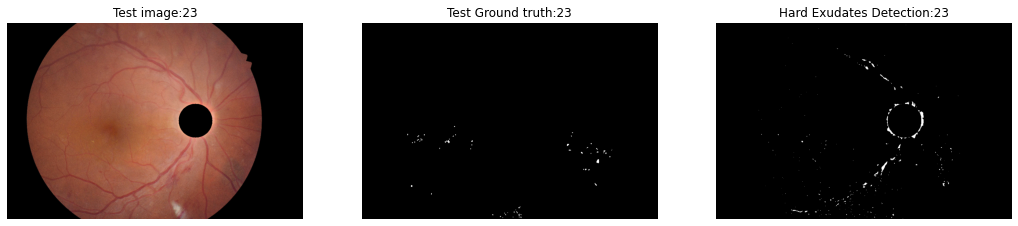

Shape of Features: (279, 94)


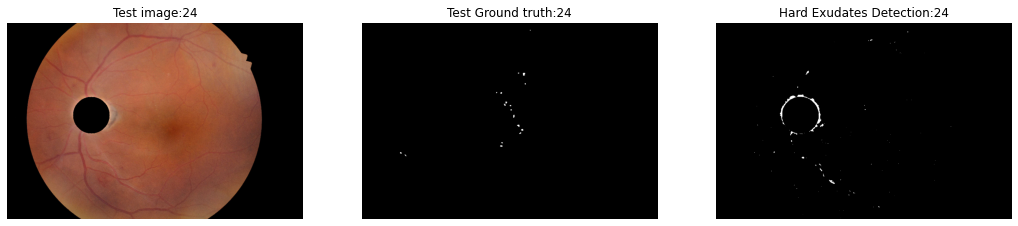

Shape of Features: (104, 94)


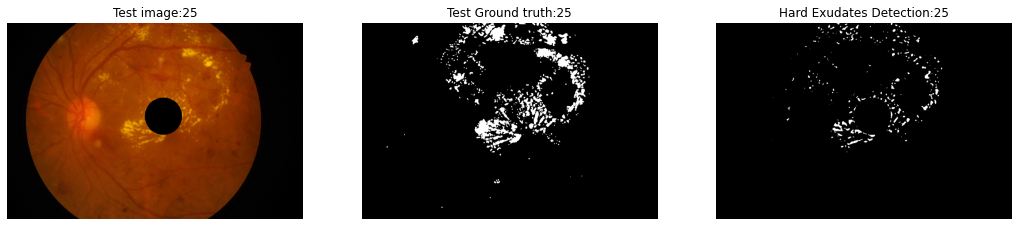

Shape of Features: (306, 94)


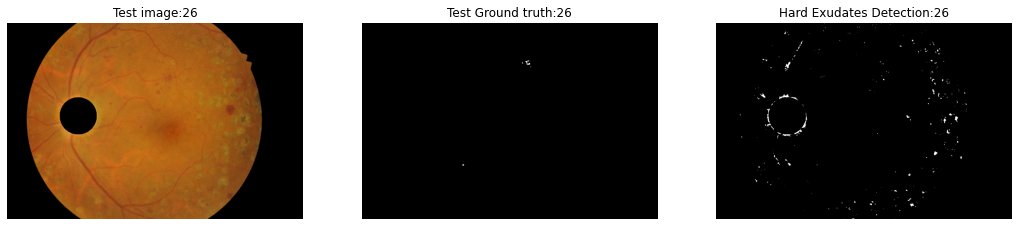

Shape of Features: (312, 94)


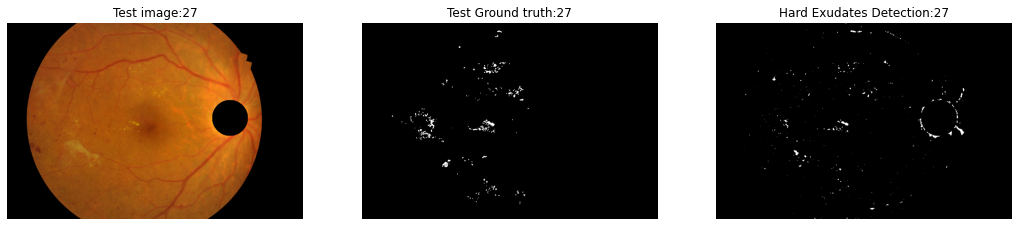

Shape of Features: (370, 94)


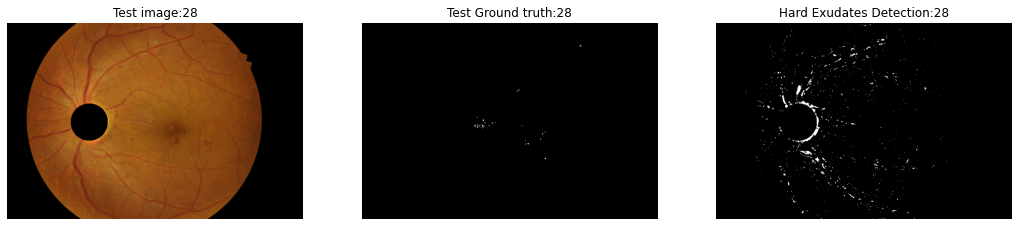

Shape of Features: (1028, 94)


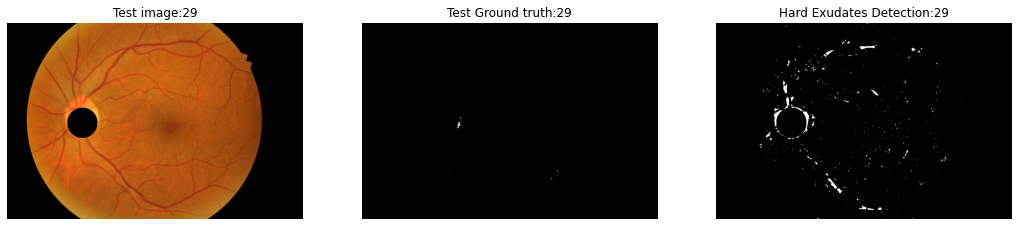

Shape of Features: (578, 94)


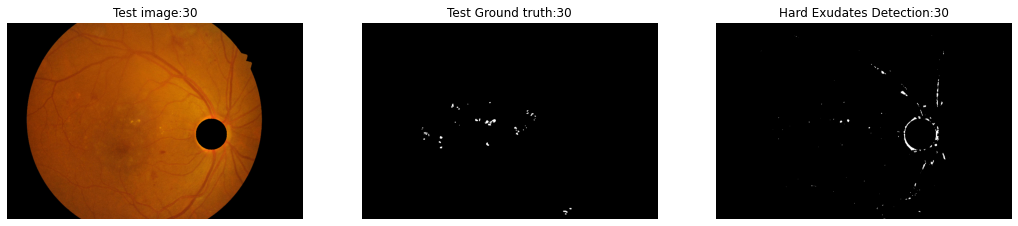

Shape of Features: (140, 94)


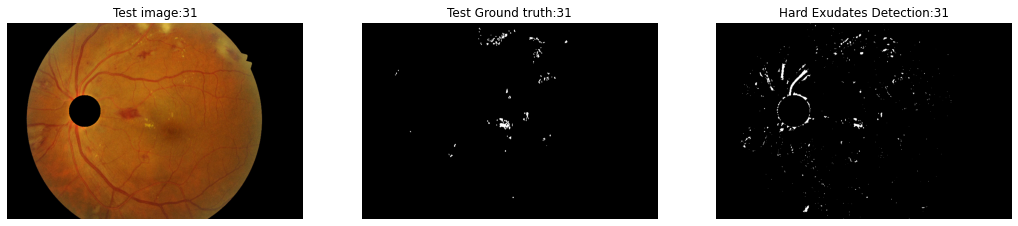

Shape of Features: (558, 94)


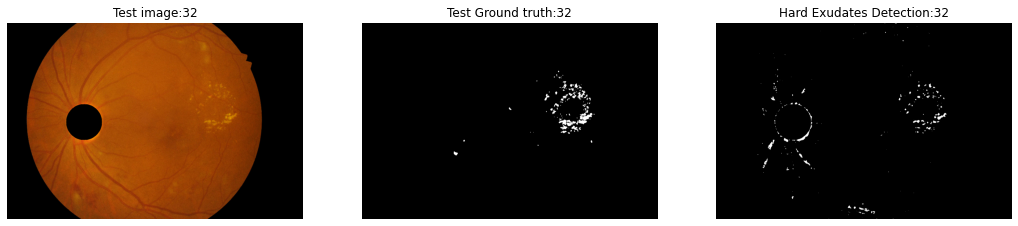

Shape of Features: (232, 94)


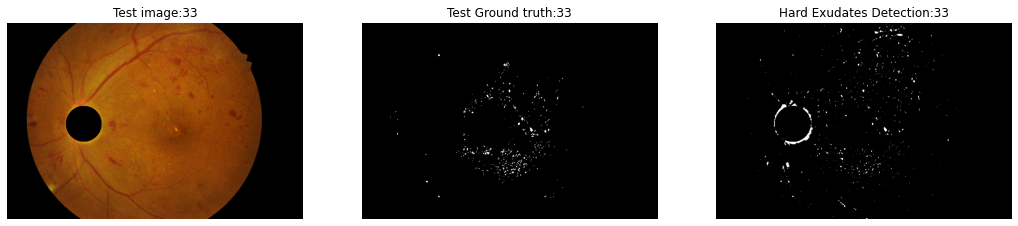

Shape of Features: (719, 94)


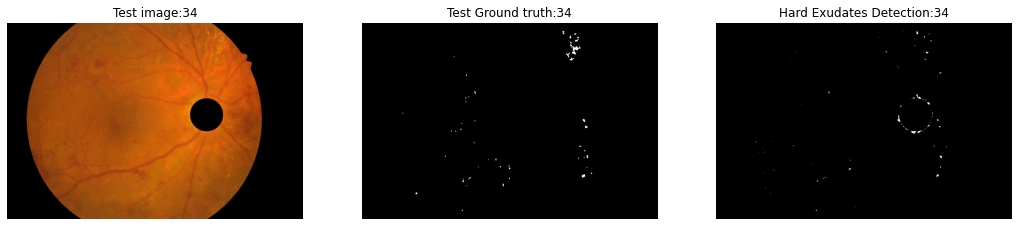

Shape of Features: (124, 94)


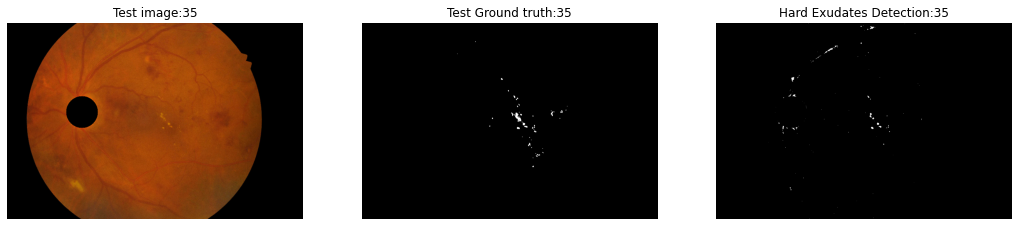

Shape of Features: (121, 94)


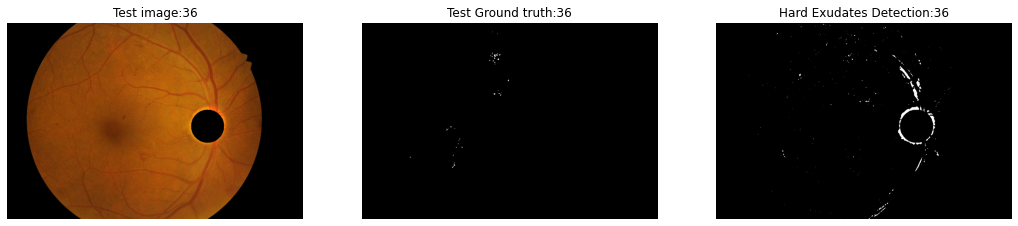

Shape of Features: (300, 94)


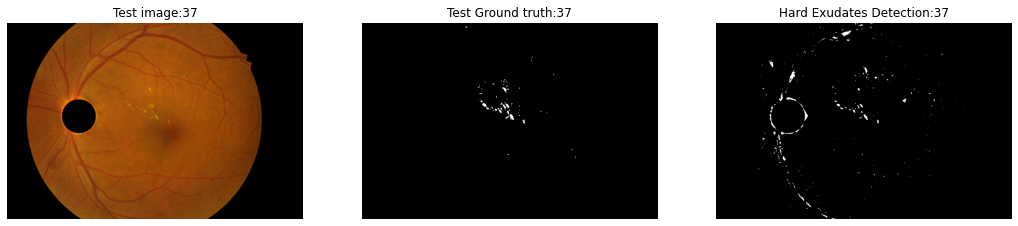

Shape of Features: (425, 94)


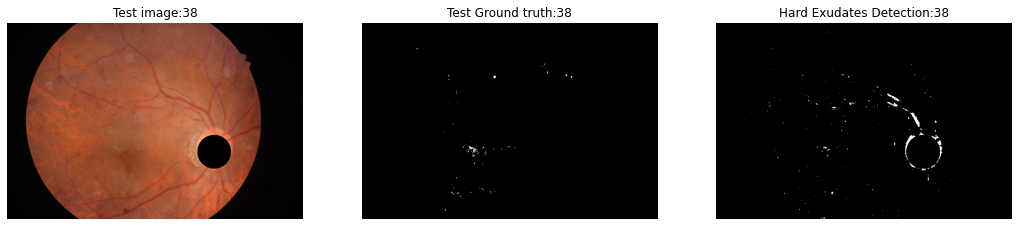

Shape of Features: (269, 94)


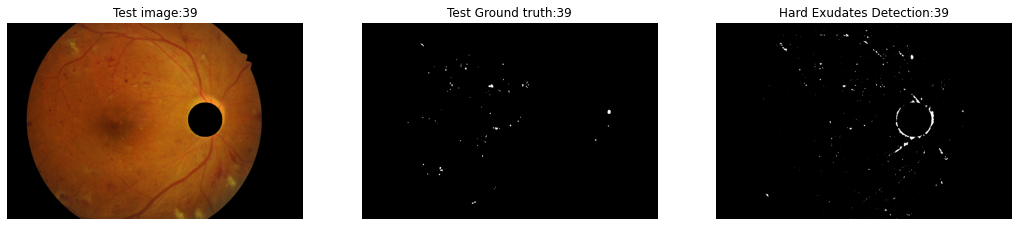

Shape of Features: (320, 94)


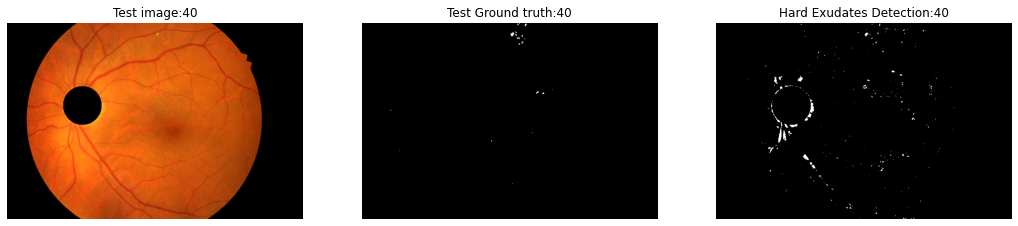

Shape of Features: (310, 94)


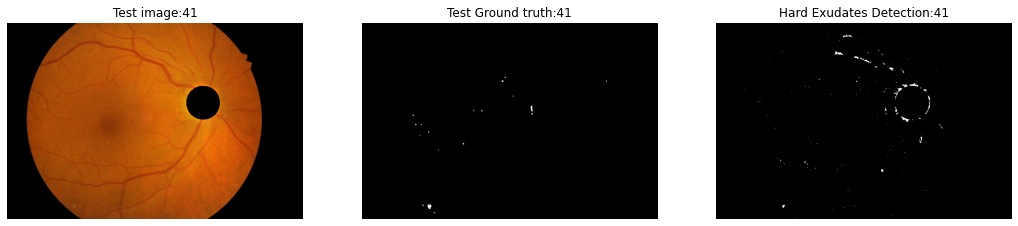

Shape of Features: (207, 94)


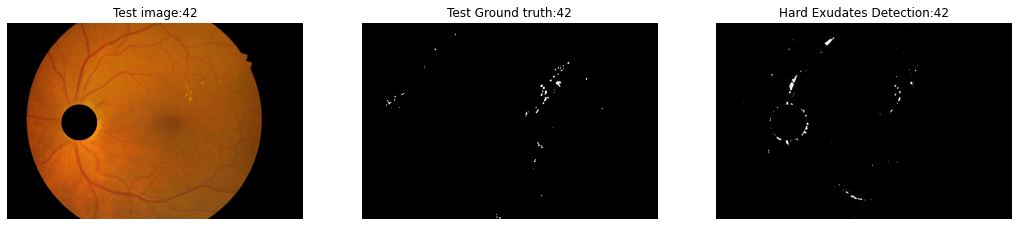

Shape of Features: (139, 94)


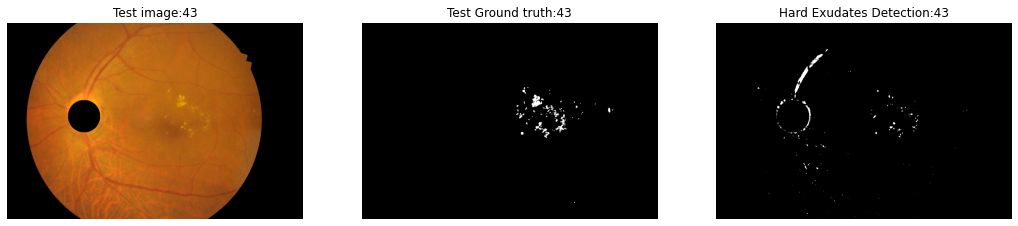

Shape of Features: (177, 94)


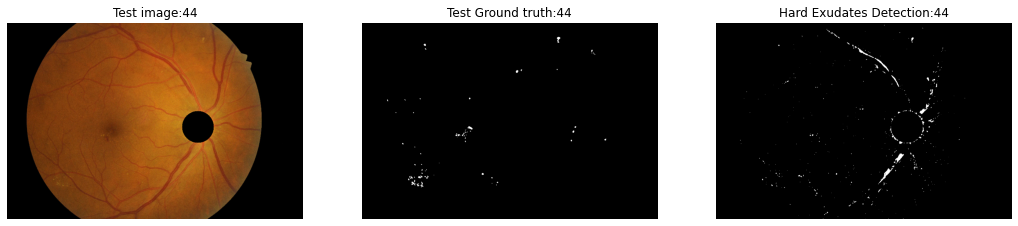

Shape of Features: (428, 94)


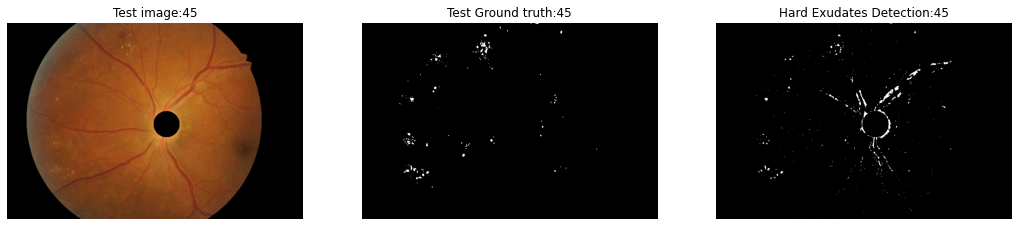

Shape of Features: (461, 94)


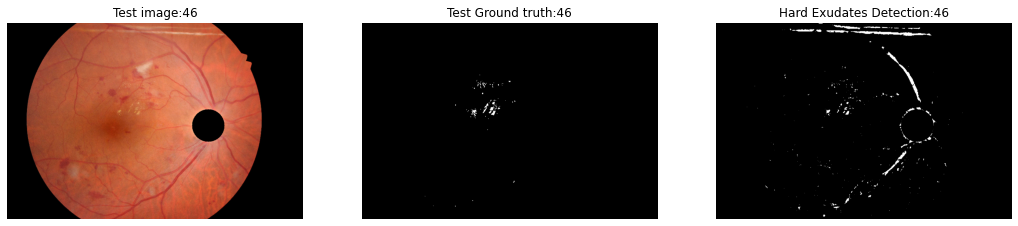

Shape of Features: (342, 94)


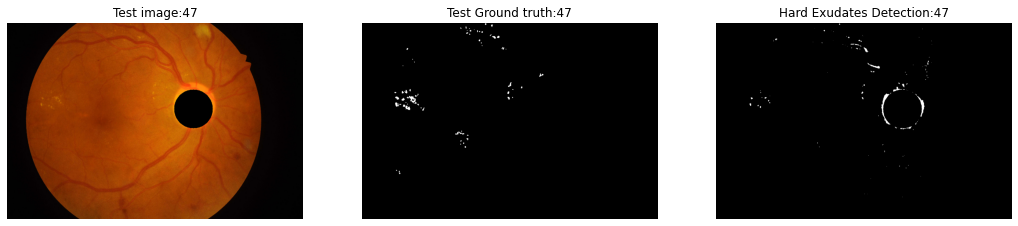

Shape of Features: (104, 94)


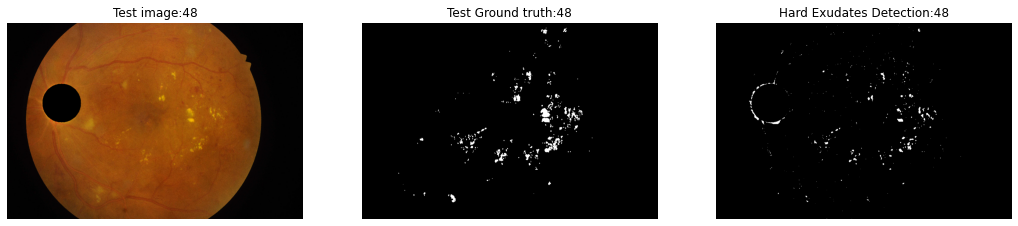

Shape of Features: (404, 94)


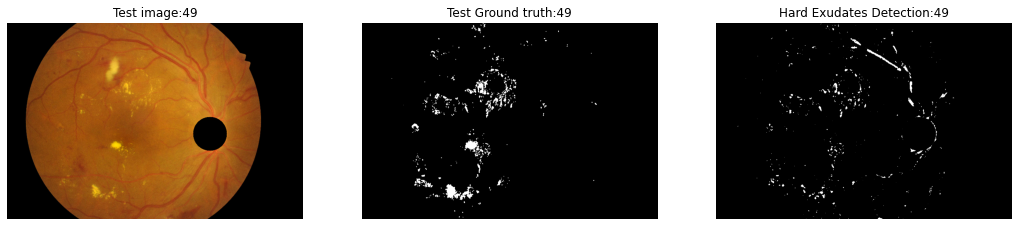

Shape of Features: (506, 94)


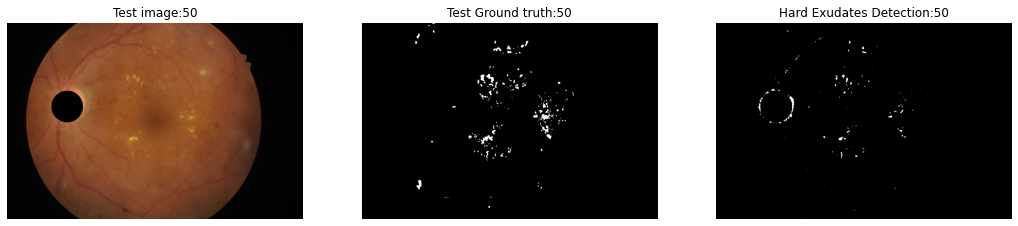

Shape of Features: (181, 94)


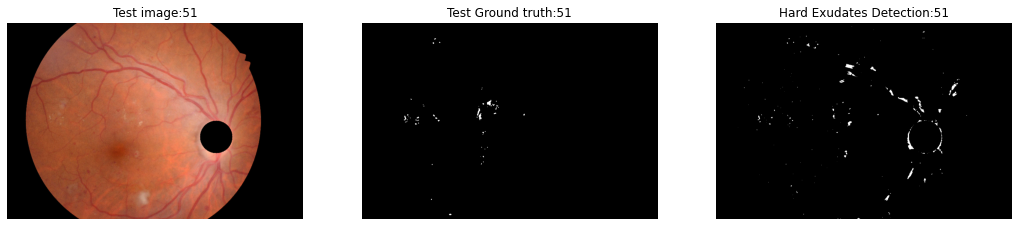

Shape of Features: (185, 94)


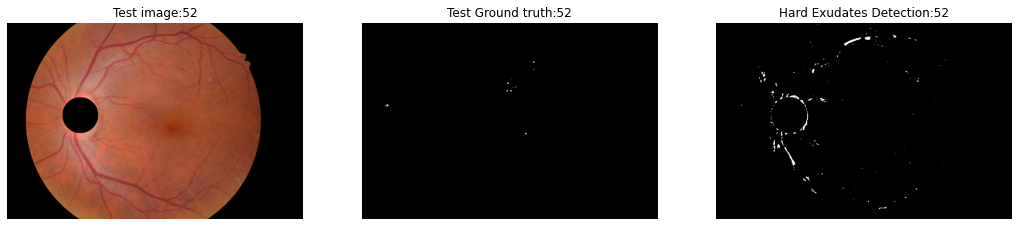

Shape of Features: (250, 94)


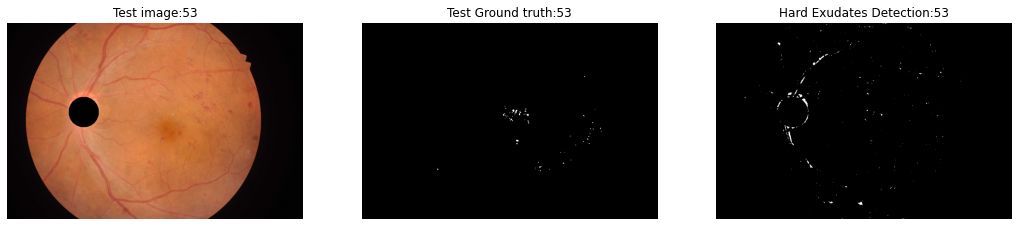

Shape of Features: (278, 94)


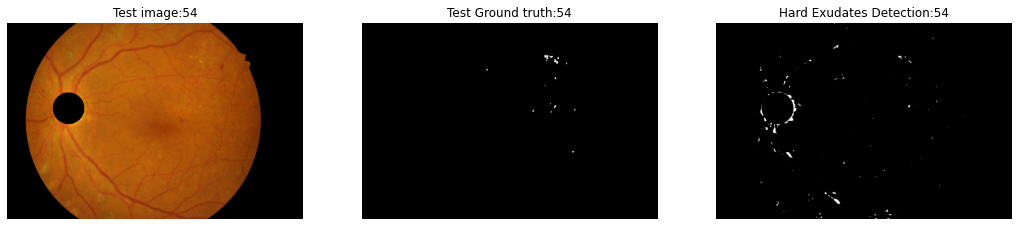

Shape of Features: (160, 94)


In [7]:
for image_number in range(1, 55):
    
# STEP1: LOAD THE DATASET
    
    # Load the training dataset
    formatted_number = str(image_number).zfill(2)
    img_path = f"Retinal Lesions Data/data/images/training/IDRiD_{formatted_number}.jpg"
    img1 = cv2.imread(img_path)
    img1 = cv2.resize(img1, dsize=None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)
    
    # Load the groundtruths
    img_path = f"Retinal Lesions Data/data/groundtruths/training/hard exudates/IDRiD_{formatted_number}_EX.tif"
    img_hex = cv2.imread(img_path)
    img_hex_gray = cv2.cvtColor(img_hex, cv2.COLOR_BGR2GRAY)
    th, img_hex_gray = cv2.threshold(img_hex_gray, 10, 255, cv2.THRESH_BINARY)


    
# STEP 2: OPTIC DISC REMOVAL

    # Set the background to zero
    _, _, red = cv2.split(img1)
    _, backgroundmask = cv2.threshold(red, thresh=30, maxval=1, type=cv2.THRESH_BINARY)
    image = cv2.bitwise_and(img1, img1, mask=backgroundmask)

    # Segmentation of the optical disc 
    image = cv2.pyrMeanShiftFiltering(image, sp=10, sr=20)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(30, 30))
    image = clahe.apply(gray)
    image = gammaCorrection(image, 2.5)
    image = linearStretching(image)
    circles = cv2.HoughCircles(image, method=cv2.HOUGH_GRADIENT, dp=1, minDist=5, param1=100, param2=10, minRadius=10, maxRadius=57)
    
    # Create a mask image with the same size as the original image
    mask = np.zeros_like(image)
    for i in range(len(circles)):
        circle = circles[0][i]
        center = (int(circle[0]), int(circle[1]))
        radius = int(circle[2])
        cv2.circle(mask, center, radius, 255, -1)  

    # Invert the mask and apply it to the original image to remove the region inside the circles    
    inverted_mask = cv2.bitwise_not(mask)
    removed_disc = cv2.bitwise_and(img1, img1, mask=inverted_mask)
    
    
# STEP 3: PREPROCESSING AND SEGMENTATION OF THE CANDIDATE REGIONS 

    # Return the image to its orginal size and split it into b, g, r
    removed_disc = cv2.resize(removed_disc, (4288,2848), interpolation=cv2.INTER_CUBIC)
    aspect_ratio  = min([1152/removed_disc.shape[0], 1500/removed_disc.shape[1]])
    img = cv2.resize(removed_disc,(int(removed_disc.shape[1]*aspect_ratio),int(removed_disc.shape[0]*aspect_ratio)), interpolation = cv2.INTER_CUBIC)
    b,g,r = cv2.split(img)         
            

    # Create two pipelines: Original images and halved images and apply morphological operations
    
    # Pipeline1: Original images
    img_enhanced = preprocess_image(g)
    img_bh = apply_blackhat(img_enhanced, (40, 40))
    img_th = apply_tophat(img_enhanced, (15, 15))
    img_hex = cv2.subtract(img_th, img_bh)
    ret, img_hex_patch = cv2.threshold(img_hex, 35, 255, cv2.THRESH_BINARY)

    # Pipeline2: Halved images
    g_half = cv2.resize(g, (int(img.shape[1]/2), int(img.shape[0]/2)), interpolation=cv2.INTER_CUBIC)
    img_enhanced_half = preprocess_image(g_half)
    img_bh_half = apply_blackhat(img_enhanced_half, (35, 35))
    img_th_half = apply_tophat(img_enhanced_half, (13, 13))
    img_hex_half = cv2.subtract(img_th_half, img_bh_half)
    ret, img_hex_patch_half = cv2.threshold(img_hex_half, 35, 255, cv2.THRESH_BINARY)
    img_hex_patch_half = cv2.resize(img_hex_patch_half, (img_hex_patch.shape[1], img_hex_patch.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # LAB Color Space Transformation
    img_erode = lab_color_space_transform(img, (15, 15))
    
    
    # Bitwise Operation of both the pipelines
    img_combine = cv2.bitwise_or(img_hex_patch, img_hex_patch_half)
    # Bitwise Operation of the above patch and the eroded lightness patch
    img_combine = cv2.bitwise_and(img_combine, img_erode)
    # Resizing to Original
    img_combine = cv2.resize(img_combine, (4288,2848), interpolation=cv2.INTER_CUBIC)
    
    
    plt.figure(figsize=(18,5))
    
# Subplot 1: Display the Test image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Test image:' + str(image_number))
    plt.axis('off')

# Subplot 2: Display the Mask
    plt.subplot(1, 3, 2)
    plt.imshow(img_hex_gray, 'gray')
    plt.title('Test Ground truth:' + str(image_number))
    plt.axis('off') 


# Subplot 3: Display HEX
    plt.subplot(1, 3, 3)
    plt.imshow(img_combine, 'gray')
    plt.title('Hard Exudates Detection:' + str(image_number))
    plt.axis('off')

    plt.show()

    image_features, label_list = all_candidates_region_selection(removed_disc, img_combine, img_hex_gray)

# Save Training set TO EXCEL
    hex_labels_new = pd.DataFrame(label_list, columns=["Label"])
    image_data = pd.concat([image_features, hex_labels_new], axis=1)
#     save_features_to_csv(image_data, 'Feature_Xtracted.csv', header=True)
    print("Shape of Features:", image_data.shape)

#     # Call the function and accumulate the exudate count
#     exudate_count = countGroundtruth(img_hex_gray)
#     total_exudate_count += exudate_count
# print("Total number of exudates/contours:", total_exudate_count)

### MACHINE LEARNING

In [8]:
# Load the extracted features
Feature_Extraction = pd.read_csv('Feature_Xtracted.csv')
print(Feature_Extraction.shape)
Feature_Extraction.head()

(16299, 94)


Image number  Region  mean_intensity  std_intensity  max_intensity  \
0             1       1       68.933333       1.948219           71.0   
1             1       2       87.738095       1.001416           90.0   
2             1       3       79.944444       1.437483           83.0   
3             1       4       93.583333       2.005202           99.0   
4             1       5       76.203704       4.896634           81.0   

   min_intensity   Energy1  Correlation1  Dissimilarity1  Homogeneity1  ...  \
0           64.0  0.372678      0.832565        1.500000      0.366667  ...   
1           86.0  0.398686      0.619517        0.583333      0.713889  ...   
2           76.0  0.323193      0.870301        0.484848      0.760606  ...   
3           91.0  0.355903      0.959996        0.600000      0.720000  ...   
4           60.0  0.174304      0.917713        1.729167      0.463664  ...   

   Hu_moment1  Hu_moment2    Hu_moment3    Hu_moment4    Hu_moment5  \
0    0.007901    0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
1    0.000035    0.000076  2.871721e-07  1.022781e-12  8.602759e-10   
2    0.000068    0.000001  4.153528e-07  2.421193e-13 -1.583027e-09   
3    0.000030    0.000251  2.037004e-07  1.457140e-12 -1.107699e-09   
4    0.004980    0.000557  9.758166e-06  5.110799e-10  6.864521e-07   

     Hu_moment6   Area  Perimeter  Eccentricity  Label  
0  0.000000e+00    8.0  12.000000      1.666667      0  
1  8.657593e-13   22.0  18.485281      1.166667      0  
2 -1.817647e-13  112.5  41.899495      1.000000      0  
3 -4.362085e-26   22.0  17.656854      1.000000      0  
4  5.059471e-10   60.0  33.313708      0.750000      0  

[5 rows x 94 columns]

In [9]:
# Let count the number of occurrences in the label column, this will allow us to know the level of class imbalance
label_counts = Feature_Extraction['Label'].value_counts()
print("Number of 1s:", label_counts[1])
print("Number of 0s:", label_counts[0])

Number of 1s: 4102
Number of 0s: 12197


#### Perform feature normalization
We have used MinMax

In [10]:
# Exclude the first two columns from normalization (Image number and region number) and apply MinMax
data_to_normalize = Feature_Extraction.iloc[:, 2:]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_features = pd.DataFrame(data=normalized_data, columns=data_to_normalize.columns)

# Concatenate the first two columns from the original DataFrame with the normalized data and save it
Feature_result = pd.concat([Feature_Extraction.iloc[:, :2], normalized_features], axis=1)
Feature_result.to_csv('Feature_result.csv', index=False)
Feature_result.head()

Image number  Region  mean_intensity  std_intensity  max_intensity  \
0             1       1        0.226599       0.024430       0.178571   
1             1       2        0.320204       0.012557       0.263393   
2             1       3        0.281410       0.018025       0.232143   
3             1       4        0.349300       0.025144       0.303571   
4             1       5        0.262789       0.061401       0.223214   

   min_intensity   Energy1  Correlation1  Dissimilarity1  Homogeneity1  ...  \
0       0.290909  0.348475      0.898924        0.037500      0.366255  ...   
1       0.390909  0.375486      0.770313        0.014583      0.713703  ...   
2       0.345455  0.297081      0.921704        0.012121      0.760450  ...   
3       0.413636  0.331052      0.975851        0.015000      0.719818  ...   
4       0.272727  0.142447      0.950326        0.043229      0.463315  ...   

   Hu_moment1    Hu_moment2    Hu_moment3  Hu_moment4  Hu_moment5  Hu_moment6  \
0    0.001106  0.000000e+00  0.000000e+00     0.09217    0.133687    0.199177   
1    0.000005  4.844524e-05  3.881667e-07     0.09217    0.133687    0.199177   
2    0.000010  8.173205e-07  5.614269e-07     0.09217    0.133687    0.199177   
3    0.000004  1.605055e-04  2.753391e-07     0.09217    0.133687    0.199177   
4    0.000697  3.556351e-04  1.318998e-05     0.09217    0.133688    0.199177   

       Area  Perimeter  Eccentricity  Label  
0  0.000167   0.002147      0.067289    0.0  
1  0.000593   0.004566      0.045502    0.0  
2  0.003344   0.013299      0.038239    0.0  
3  0.000593   0.004257      0.038239    0.0  
4  0.001748   0.010097      0.027345    0.0  

[5 rows x 94 columns]

#### Principal Component Analysis

1. This allows us to reduce the curse of dimensionality.
2. After several components, n = 50 was the best along with the grid search

In [11]:
# Separate the data into y (labels), and X (features) - without the first two columns (Image number and regions)
y = Feature_result['Label'] 
X_features = Feature_result.iloc[:, 2:].drop('Label', axis=1)
X_features.head()

mean_intensity  std_intensity  max_intensity  min_intensity   Energy1  \
0        0.226599       0.024430       0.178571       0.290909  0.348475   
1        0.320204       0.012557       0.263393       0.390909  0.375486   
2        0.281410       0.018025       0.232143       0.345455  0.297081   
3        0.349300       0.025144       0.303571       0.413636  0.331052   
4        0.262789       0.061401       0.223214       0.272727  0.142447   

   Correlation1  Dissimilarity1  Homogeneity1  Contrast1   Energy2  ...  \
0      0.898924        0.037500      0.366255   0.001644  0.368514  ...   
1      0.770313        0.014583      0.713703   0.000394  0.388730  ...   
2      0.921704        0.012121      0.760450   0.000318  0.275126  ...   
3      0.975851        0.015000      0.719818   0.000493  0.348608  ...   
4      0.950326        0.043229      0.463315   0.003520  0.157035  ...   

   Hu_moment0  Hu_moment1    Hu_moment2    Hu_moment3  Hu_moment4  Hu_moment5  \
0    0.011703    0.001106  0.000000e+00  0.000000e+00     0.09217    0.133687   
1    0.004568    0.000005  4.844524e-05  3.881667e-07     0.09217    0.133687   
2    0.006277    0.000010  8.173205e-07  5.614269e-07     0.09217    0.133687   
3    0.004276    0.000004  1.605055e-04  2.753391e-07     0.09217    0.133687   
4    0.013876    0.000697  3.556351e-04  1.318998e-05     0.09217    0.133688   

   Hu_moment6      Area  Perimeter  Eccentricity  
0    0.199177  0.000167   0.002147      0.067289  
1    0.199177  0.000593   0.004566      0.045502  
2    0.199177  0.003344   0.013299      0.038239  
3    0.199177  0.000593   0.004257      0.038239  
4    0.199177  0.001748   0.010097      0.027345  

[5 rows x 91 columns]

In [12]:
# Perform PCA on X features
pca = PCA(n_components=50)
X = pca.fit_transform(X_features)

#### Building our Support Vector Machine (SVM model)

1. Parameter Grid: We have defined a parameter grid that consists of different values for the 'C' and 'gamma' hyperparameters. 2. Scoring Metrics: In order to evaluate the performance of our model, we have chosen the area under the receiver operating characteristic curve (AUC) as our scoring metric.
3. SVM Classifier with Class Weighting: To handle the class imbalance in our dataset, we have set the class_weight parameter to 'balanced'.
4. Grid Search with Cross-Validation: We have performed a grid search with stratified 10-fold cross-validation to identify the best combination of hyperparameters.

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.utils import shuffle

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
}

# Define the scoring metric (AUC) and create a scorer object
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Initialize SVM classifier
svm = SVC(class_weight='balanced', probability=True)

# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring=scorer, cv=StratifiedKFold(n_splits=10))
grid_search.fit(X, y)

# Print the best parameters and the corresponding AUC score
print("Best Parameters: ", grid_search.best_params_)
# print("Best AUC Score: {:.4f}".format(grid_search.best_score_))

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Perform predictions on the entire dataset using the best model
predictions = best_model.predict_proba(X)[:, 1]  # Probability of belonging to class 1

# Print the array of scores for each sample
print("Scores for each sample: ", predictions)

Best Parameters:  {'C': 100, 'gamma': 0.1}
Scores for each sample:  [0.08296203 0.06323506 0.05909879 ... 0.12927222 0.20753069 0.24149733]


In [14]:
# Store the scores in the feature_result data
Feature_result['Scores'] = predictions

# Create a new dataframe Feature_eval
Feature_eval = pd.DataFrame(columns=['Image number', 'Region', 'Scores', 'Label'])

# Copy the required columns from feature_result to Feature_eval
Feature_eval['Image number'] = Feature_result['Image number']
Feature_eval['Region'] = Feature_result['Region']
Feature_eval['Scores'] = Feature_result['Scores']
Feature_eval['Label'] = Feature_result['Label']
Feature_eval.head(5)

Image number  Region    Scores  Label
0             1       1  0.082962    0.0
1             1       2  0.063235    0.0
2             1       3  0.059099    0.0
3             1       4  0.049419    0.0
4             1       5  0.306717    0.0

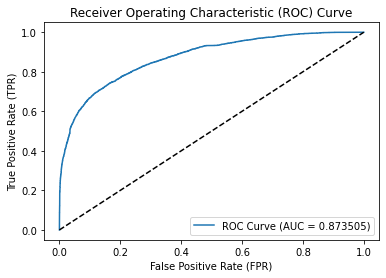

AUC: 0.873505


In [15]:
# Extract scores
scores = Feature_eval['Scores'].values
label = Feature_eval['Label'].values

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(label, scores)

# Calculate the AUC (Area Under the Curve)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.6f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label= '')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC: {:.6f}'.format(auc_score))


### THANK YOU